In [357]:
import random
import nltk, re, pprint
from nltk import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
import copy
import numpy as np
import seaborn as sns
import itertools
import pickle
import math
import networkx as nx
import community
import pickle 
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
from operator import itemgetter
from fa2 import ForceAtlas2
sns.set()
%matplotlib inline

# Comparison Books vs. Movies 

## TF in Books vs. Movies
The first step is to import the dataframe containing all the information from the movie scripts. The titles of all the movies are also added manually.

In [356]:
# Read pickled object and see how it looks
df = pd.read_pickle("./movie_scripts.pkl")

# All the movie titles in correct order
movie_titles = ["Harry Potter and the Philosopher's Stone","Harry Potter and the Chamber of Secrets",
              "Harry Potter and the Prisoner of Azkaban","Harry Potter and the Goblet of Fire",
              "Harry Potter and the Order of the Phoenix","Harry Potter and the Half-Blood Prince",
              "Harry Potter and the Deathly Hallows – Part 1","Harry Potter and the Deathly Hallows – Part 2"]
movie_titles_short = [move_titles[i].split("Harry Potter and the ", 1)[1] for i in range(len(move_titles))]

The next step is to convert the dataframe into a dictionary, where each key is the movie number. All the sentences said in that movie are tokenized, lemmetized and stopwords removed. That way it's easy to generate a Frequency Distribution which includes all the clean words said in each movie. This will be the basis needed to create a comparison between the movies and books.

In [9]:
# Add new column to dataframe that include the tokenized sentences
# Function to calculate the sentiment of tokenized list
def tokenize(text):
    #toxenize the text 
    tokens = nltk.word_tokenize(text)
    words = [w.lower() for w in tokens if w.isalpha()]
    lem_words = [wnl.lemmatize(w) for w in words if w not in stopwords]
    return(lem_words)

stopwords = nltk.corpus.stopwords.words('english')
wnl = nltk.WordNetLemmatizer()

In [104]:
# Lets combine all sentences of characters into a dictionary
char_sentences = dict()
for character in df.character.unique():
    text = tokenize(df.sentence[df.character == character].str.cat(sep=' '))
    char_sentences[character] = text
    
# Lets combine all sentences for each movie into a dictionary
movie_sentences = dict()
for movie in df.movie_nr.unique():
    text = tokenize(df.sentence[df.movie_nr == movie].str.cat(sep=' '))
    movie_sentences[movie] = text
    
# maybe have dictionary that has the key movie, that has the key of character and and the value as sentence

In [105]:
# Generate a list with all of the frequency distributions of the movies and normalized frequencies
movies_freqdist = []
movies_freqdist_norm = []
for i in range(len(movie_titles)):
    movies_freqdist.append(nltk.FreqDist(movie_sentences[i+1]))
    movies_freqdist_norm.append(nltk.FreqDist(movie_sentences[i+1]))
    
# Normalize the word count for the word count of each movie
for movie in movies_freqdist_norm:
    total_length = sum(movie.values())
    for word in movie:
        movie[word] = movie[word] / total_length

In [106]:
movies_freqdist_norm[0].most_common(5)

[('harry', 0.028719229397074563),
 ('go', 0.010524438102033535),
 ('see', 0.00945415626114877),
 ('come', 0.008919015340706386),
 ('ron', 0.008919015340706386)]

Now we have a list of all the movies with normalized frequency distributions. 
Then the next step is to gather the same data for the books. The pickled list of books is collected and the normalized frequency distribution shown.

In [107]:
# read books from pickled object
# Read pickled object and see how it looks
books = pd.read_pickle("../actual_books/books_list_final.pkl")

In [108]:
books[0]['fdist_norm'].most_common(5)

[('harry', 0.03271443385511827),
 ('said', 0.01960397017431238),
 ('ron', 0.010592069527430744),
 ('hagrid', 0.009110661201915955),
 ('could', 0.007481112043849687)]

Just from this simple analysis it can be seen that there are some differences in scale. **Harry** appears slightly more in the first book than in the first movie.

For the comparison, we gather the set of 10 most common words for the books and the top 10 most common words for the movies into a single set. In order to do so it is necessary to combine all the frequency distributions for the books into a single frequency distribution. This is simple, since frequency distribution objects can be summed together. The same will be done to combine all the movies into a single frequency distribution.

In [125]:
total_freqdist_movies = movies_freqdist[0] + movies_freqdist[1] + movies_freqdist[2] + movies_freqdist[3] + movies_freqdist[4] + movies_freqdist[5] + movies_freqdist[6] + movies_freqdist[7]
total_freqdist_books = books[0]['fdist'] + books[1]['fdist'] + books[2]['fdist'] + books[3]['fdist'] + books[4]['fdist'] + books[5]['fdist'] + + books[6]['fdist']
word_set_to_use = set([term for (term,freq) in total_freqdist_books.most_common(10)] + [term for (term,freq) in total_freqdist_movies.most_common(10)])
print(word_set_to_use)

{'harry', 'could', 'know', 'see', 'hermione', 'said', 'dumbledore', 'think', 'go', 'one', 'right', 'potter', 'ron', 'well', 'back', 'would', 'come'}


Now the frequency of each of those words is extracted from the two frequency distributions. In order for the values to be comparible, it is necessary to normalize each value by the word.....

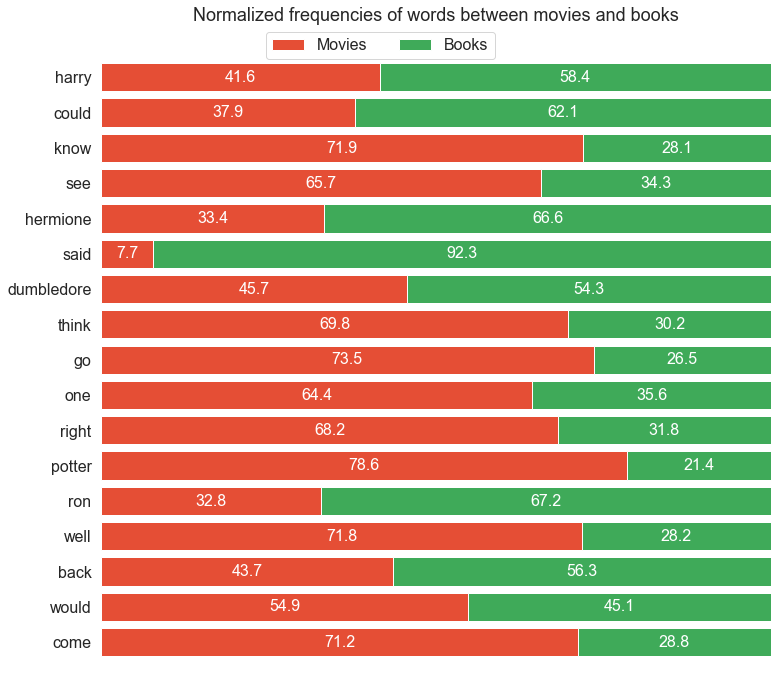

In [236]:
# Code adjusted from https://github.com/haideralipunjabi/harrypotter-analysis/blob/master/make_graph.py
# Explained here: https://blog.haideralipunjabi.com/posts/harry-potter-books-fanfiction-an-analysis-of-words/

# Generate the normalized values of the word set for both movies and books
data = {}
total_count_movies = sum(total_freqdist_movies.values())
total_count_books = sum(total_freqdist_books.values())
for key in list(word_set_to_use):
    word_data = [total_freqdist_movies[key]/total_count_movies,0]
    if key in total_freqdist_books.keys():
        word_data[1] = (total_freqdist_books[key]/total_count_books)
    data[key] = word_data

# Then normalize the data - so that each normalized word freq for movie and books sum to 100
for key in data.keys():
    total = data[key][0] + data[key][1]
    data[key][0] = data[key][0]*100/total
    data[key][1] = data[key][1]*100/total

# Copy the data for easier reference between cells
actual_data = data.copy()

# Plot the values
sns.set_theme(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

results = actual_data
category_names = ['Movies', 'Books']
ann = list(actual_data.values())

labels = list(results.keys())
data = np.array(list(results.values()))
data_cum = data.cumsum(axis=1)

category_colors = plt.get_cmap('RdYlGn')(
    np.linspace(0.15, 0.85, data.shape[1]))

fig, ax = plt.subplots(figsize=(12,12))
ax.grid(False)
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, np.sum(data, axis=1).max())

for i, (colname, color) in enumerate(zip(category_names, category_colors)):
    widths = data[:, i]
    starts = data_cum[:, i] - widths
    ax.barh(labels, widths, left=starts, height=0.8,
            label=colname, color=color)
    xcenters = starts + widths / 2

    r, g, b, _ = color
    text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
    for y, (x, c) in enumerate(zip(xcenters, widths)):
        if(c < 5):
            x -= 5
        ax.text(x, y, round(ann[y][i],1), ha='center', va='center',
                color=text_color, fontsize=16)
    ax.yaxis.set_tick_params(labelsize=16)

ax.legend(ncol=len(category_names), bbox_to_anchor=(0.6, 1.015),
          loc='upper right', fontsize=16, frameon=True);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title('Normalized frequencies of words between movies and books', fontsize=18, y = 1.01);

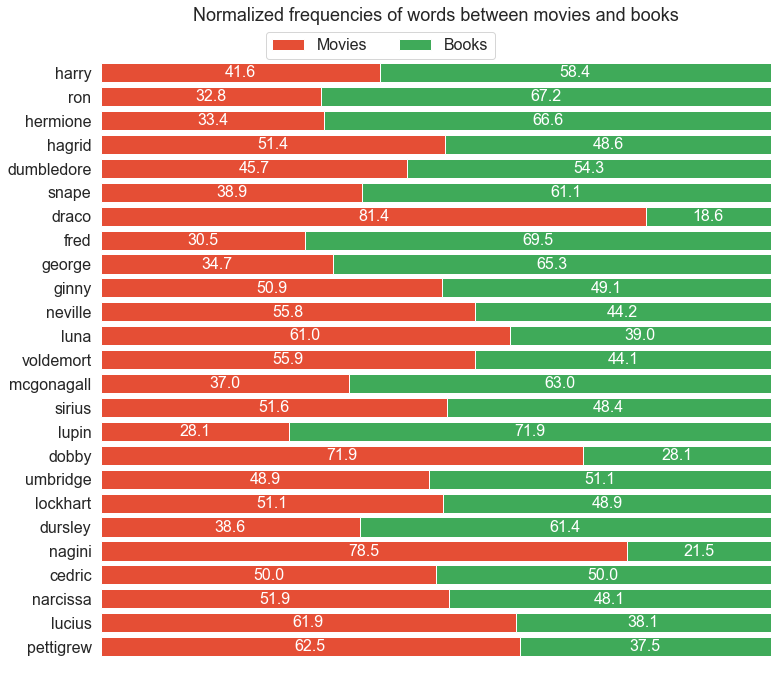

In [238]:
# Code adjusted from https://github.com/haideralipunjabi/harrypotter-analysis/blob/master/make_graph.py
# Explained here: https://blog.haideralipunjabi.com/posts/harry-potter-books-fanfiction-an-analysis-of-words/

new_word_set_to_use = ['harry', 'ron', 'hermione', 'hagrid', 'dumbledore', 'snape', 'draco', 'fred', 'george', 'ginny', 'neville', 'luna', 'voldemort', 'mcgonagall', 'sirius', 'lupin', 'dobby', 'umbridge', 'lockhart', 'dursley', 'nagini', 'cedric', 'narcissa', 'lucius', 'pettigrew']

# Generate the normalized values of the word set for both movies and books
data = {}
total_count_movies = sum(total_freqdist_movies.values())
total_count_books = sum(total_freqdist_books.values())
for key in list(new_word_set_to_use):
    word_data = [total_freqdist_movies[key]/total_count_movies,0]
    if key in total_freqdist_books.keys():
        word_data[1] = (total_freqdist_books[key]/total_count_books)
    data[key] = word_data

# Then normalize the data - so that each normalized word freq for movie and books sum to 100
for key in data.keys():
    total = data[key][0] + data[key][1]
    data[key][0] = data[key][0]*100/total
    data[key][1] = data[key][1]*100/total

# Copy the data for easier reference between cells
actual_data = data.copy()

# Plot the values
sns.set_theme(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

results = actual_data
category_names = ['Movies', 'Books']
ann = list(actual_data.values())

labels = list(results.keys())
data = np.array(list(results.values()))
data_cum = data.cumsum(axis=1)

category_colors = plt.get_cmap('RdYlGn')(
    np.linspace(0.15, 0.85, data.shape[1]))

fig, ax = plt.subplots(figsize=(12,12))
ax.grid(False)
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, np.sum(data, axis=1).max())

for i, (colname, color) in enumerate(zip(category_names, category_colors)):
    widths = data[:, i]
    starts = data_cum[:, i] - widths
    ax.barh(labels, widths, left=starts, height=0.8,
            label=colname, color=color)
    xcenters = starts + widths / 2

    r, g, b, _ = color
    text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
    for y, (x, c) in enumerate(zip(xcenters, widths)):
        if(c < 5):
            x -= 5
        ax.text(x, y, round(ann[y][i],1), ha='center', va='center',
                color=text_color, fontsize=16)
    ax.yaxis.set_tick_params(labelsize=16)

ax.legend(ncol=len(category_names), bbox_to_anchor=(0.6, 1.015),
          loc='upper right', fontsize=16, frameon=True);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title('Normalized frequencies of words between movies and books', fontsize=18, y = 1.01);

# Sentiment

In [294]:
Finally we compare the evolution of 

In [314]:
# Collect sentiment from books
sentiment_books = []
sentiment_chapters = []
cumulative_chapters = np.cumsum([books[i]['nr_chapters'] for i in range(len(books))])
for book in books:
    sentiment_books.append(book['avg_sentiment'])
    for chapter in book['chapters']:
        sentiment_chapters.append(chapter['avg_sentiment'])
        
# Generate the 5 chapter MA
sentiment_chapters_MA = pd.DataFrame(sentiment_chapters).rolling(window=5).mean()
sentiment_chapters_MA.rename(columns = {0: 'moving_average'}, inplace = True)

In [327]:
# Collect sentiment from movies
sentiment_movies = []
sentiment_scenes = []
cumulative_scenes = []
for i in range(8):
    sentiment_movies.append(np.mean(df[df.movie_nr==(i+1)].sentence_sent))
    scen_count = 0
    for j in range(max(df[df.movie_nr==(i+1)].scene_id)):
        if str(np.mean(df[(df.movie_nr==(i+1)) & (df.scene_id == (j+1))].sentence_sent)) != 'nan':
            sentiment_scenes.append(np.mean(df[(df.movie_nr==(i+1)) & (df.scene_id == (j+1))].sentence_sent))
            scen_count += 1
    cumulative_scenes.append(scen_count)

# Generate the cumulative count of scenes
cumulative_scenes = np.cumsum(cumulative_scenes)

# Generate the 5 chapter MA
sentiment_scenes_MA = pd.DataFrame(sentiment_scenes).rolling(window=30).mean()
sentiment_scenes_MA.rename(columns = {0: 'moving_average'}, inplace = True)

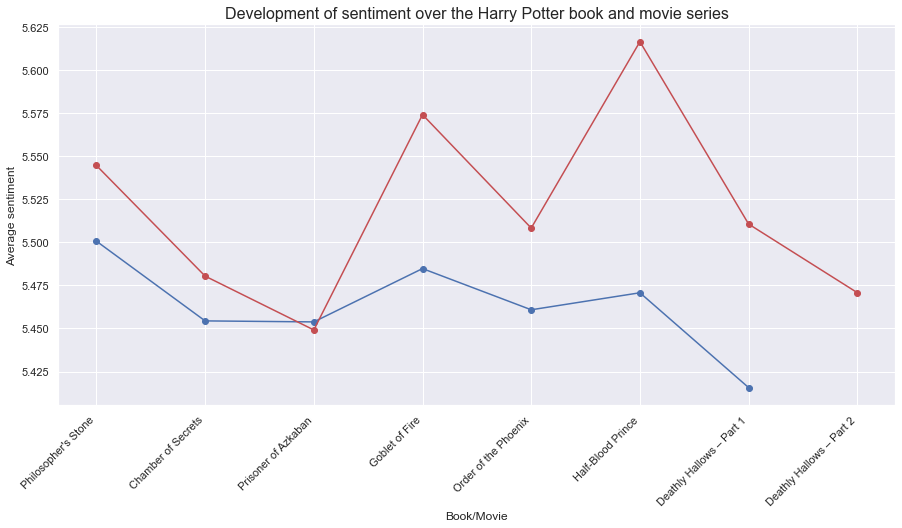

In [355]:
# Plot the development of sentiment
plt.figure(figsize=(15,7))
plt.plot(sentiment_books, 'bo-');
plt.plot(sentiment_movies, 'ro-');
plt.title('Development of sentiment over the Harry Potter book and movie series', fontsize=16)
plt.xlabel('Book/Movie')
plt.xticks(range(len(sentiment_movies)), movie_titles_short, rotation=45, ha="right")  # Set locations and labels
plt.ylabel('Average sentiment');

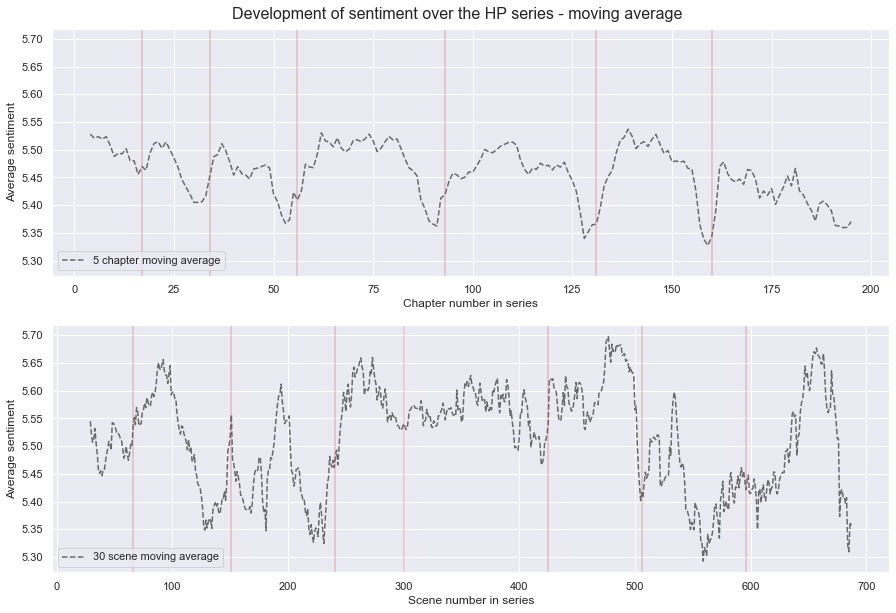

In [347]:
# Plot
fig, axs = plt.subplots(2, sharey=True, figsize=(15,10))
fig.suptitle('Development of sentiment over the HP series - moving average', size=16, y = 0.91)
axs[0].plot(sentiment_chapters_MA.index, sentiment_chapters_MA.moving_average, '--', color='dimgray', label='Moving Average');    
for c in cumulative_chapters[:-1]:
    axs[0].axvline(x=c, alpha = 0.3, color='r')
axs[0].legend(['5 chapter moving average'], loc='lower left')
axs[0].set_xlabel('Chapter number in series')
axs[0].set_ylabel('Average sentiment');

axs[1].plot(sentiment_scenes_MA.index, sentiment_scenes_MA.moving_average, '--', color='dimgray', label='Moving Average');
for c in cumulative_scenes[:-1]:
    axs[1].axvline(x=c, alpha = 0.3, color='r')
axs[1].legend(['30 scene moving average'], loc='lower left')
axs[1].set_xlabel('Scene number in series')
axs[1].set_ylabel('Average sentiment');